<a href="https://colab.research.google.com/github/PaulRobertH/wine-ml-portfolio/blob/main/7_ML_FutureReturns_Forecast_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
✅ Google Drive mounted
✅ Raw data loaded with shape: (190, 27)
✅ Dropped fully NaN columns, new shape: (190, 26)
✅ Missing data imputed
Fib 61.8% level from 2015 low to ATH: 352.67
✅ Feature engineering complete. Data shape: (38, 41)
✅ Cycle phase encoded. New shape: (38, 41)
✅ HMM states added.
✅ Found 2 peaks and 2 troughs.
✅ Features and target ready: (38, 42) (38,)
✅ Model trained: RandomForest
✅ Model trained: GradientBoosting


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: Convergen

✅ Model trained: GaussianProcess
              Model       MAE      RMSE        R2
0      RandomForest  0.086346  0.099791  0.489672
1  GradientBoosting  0.084428  0.098680  0.500967
2   GaussianProcess  0.129712  0.149493 -0.145278
✅ Best model: GradientBoosting
✅ Multi-step forecast complete.
✅ Monte Carlo simulation complete.


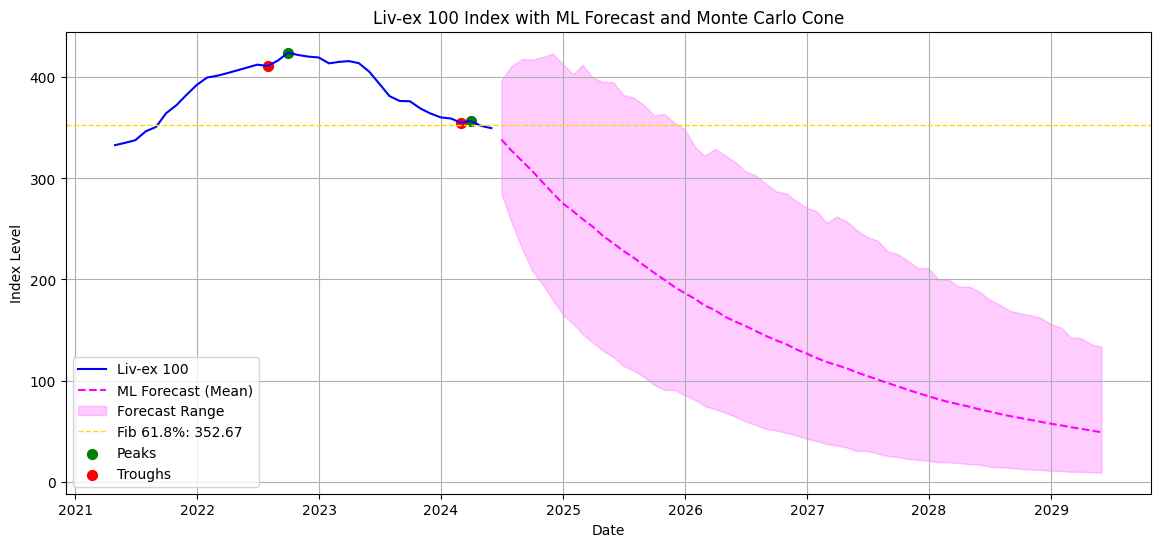

Average bear duration (months): 17.233333333333334
Average bear return (%): -16.304936962413098
Latest momentum:
momentum_3m    -0.015289
momentum_6m    -0.039995
momentum_12m   -0.137917
Name: 2024-05-31 00:00:00, dtype: float64
Current drawdown from ATH: -17.58%


In [4]:
# ------------------------------------------------------------
# ✅ INSTALL LIBRARIES (Colab-compatible)
# ------------------------------------------------------------

!pip install hmmlearn scikit-learn scipy matplotlib pandas

# ------------------------------------------------------------
# ✅ IMPORTS
# ------------------------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from sklearn.model_selection import TimeSeriesSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from hmmlearn.hmm import GaussianHMM
from scipy.signal import find_peaks
from google.colab import drive
import os

# ------------------------------------------------------------
# ✅ MOUNT GOOGLE DRIVE
# ------------------------------------------------------------

drive.mount('/content/drive', force_remount=True)
print("✅ Google Drive mounted")

DATA_PATH = '/content/drive/MyDrive/ML-Portfolio/data/'
FIG_PATH = '/content/drive/MyDrive/ML-Portfolio/figures/'

# ------------------------------------------------------------
# ✅ LOAD DATA
# ------------------------------------------------------------

csv_path = os.path.join(DATA_PATH, "merged_prepared_data_with_preds.csv")
df = pd.read_csv(csv_path, parse_dates=['Unnamed: 0'])
df = df.rename(columns={'Unnamed: 0': 'date'})
df = df.set_index('date')

print("✅ Raw data loaded with shape:", df.shape)

# Drop fully-NaN columns
df = df.dropna(axis=1, how='all')
print("✅ Dropped fully NaN columns, new shape:", df.shape)

# ------------------------------------------------------------
# ✅ IMPUTE MISSING DATA
# ------------------------------------------------------------

columns_to_impute = [c for c in df.columns if c not in ['cycle_phase', 'Predicted_12M_Return']]
imputer = SimpleImputer(strategy='mean')
imputed = imputer.fit_transform(df[columns_to_impute])
df[columns_to_impute] = pd.DataFrame(imputed, columns=columns_to_impute, index=df.index)

print("✅ Missing data imputed")

# ------------------------------------------------------------
# ✅ FEATURE ENGINEERING
# ------------------------------------------------------------

df['lag_12m_ret'] = df['wine_12m_ret'].shift(1)
df['rolling_vol'] = df['wine_12m_ret'].rolling(window=12).std()
df['momentum_3m'] = df['Liv-ex 100'].pct_change(3)
df['momentum_6m'] = df['Liv-ex 100'].pct_change(6)
df['momentum_12m'] = df['Liv-ex 100'].pct_change(12)
df['drawdown'] = df['Liv-ex 100'] / df['Liv-ex 100'].cummax() - 1

peak = df['Liv-ex 100'].cummax()
trough = df['Liv-ex 100'].cummin()
df['at_peak'] = (df['Liv-ex 100'] == peak).astype(int)
df['at_trough'] = (df['Liv-ex 100'] == trough).astype(int)

low_2015 = df.loc['2015-01-01':'2015-12-31']['Liv-ex 100'].min()
ath = df['Liv-ex 100'].max()
fib_0618 = low_2015 + 0.618 * (ath - low_2015)
df['fib_0618_level'] = fib_0618
df['above_fib_0618'] = (df['Liv-ex 100'] > fib_0618).astype(int)

print(f"Fib 61.8% level from 2015 low to ATH: {fib_0618:.2f}")

cpi_pct = df['ECONOMICS_USCPI, M'].pct_change(12).fillna(0)
df['high_inflation'] = (cpi_pct > 0.03).astype(int)
df['interest_rate_level'] = (df['ECONOMICS_USINTR, 1M'] > 2.0).astype(int)

for col in ['TVC_USOIL, 1M', 'CME_MINI_ES1!, 1M (1)', 'TVC_DXY, 1M']:
    if col in df.columns:
        df[f'{col}_mom'] = df[col].pct_change(12)

df = df.dropna()
print("✅ Feature engineering complete. Data shape:", df.shape)

# ------------------------------------------------------------
# ✅ ENCODE CATEGORICAL FEATURES
# ------------------------------------------------------------

if 'cycle_phase' in df.columns:
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoded = encoder.fit_transform(df[['cycle_phase']].fillna('Unknown'))
    encoded_cols = encoder.get_feature_names_out(['cycle_phase'])
    df_encoded = pd.DataFrame(encoded, columns=encoded_cols, index=df.index)
    df = pd.concat([df, df_encoded], axis=1)
    print("✅ Cycle phase encoded. New shape:", df.shape)

# ------------------------------------------------------------
# ✅ HMM TO DETECT CYCLES
# ------------------------------------------------------------

hmm_features = df[['lag_12m_ret', 'rolling_vol']].values
hmm_model = GaussianHMM(n_components=3, n_iter=200, random_state=42)
hmm_model.fit(hmm_features)
hidden_states = hmm_model.predict(hmm_features)
df['hmm_state'] = hidden_states

posterior_probs = hmm_model.predict_proba(hmm_features)
for i in range(hmm_model.n_components):
    df[f'hmm_prob_{i}'] = posterior_probs[:, i]

print("✅ HMM states added.")

# ------------------------------------------------------------
# ✅ PEAK/TROUGH DETECTION
# ------------------------------------------------------------

peaks, _ = find_peaks(df['Liv-ex 100'], distance=12)
troughs, _ = find_peaks(-df['Liv-ex 100'], distance=12)

df['peak'] = 0
df['trough'] = 0
df.loc[df.iloc[peaks].index, 'peak'] = 1
df.loc[df.iloc[troughs].index, 'trough'] = 1

print(f"✅ Found {len(peaks)} peaks and {len(troughs)} troughs.")

# ------------------------------------------------------------
# ✅ DEFINE FEATURES
# ------------------------------------------------------------

features = [
    col for col in df.columns
    if col not in ['Liv-ex 100', 'wine_12m_ret', 'target', 'Predicted_12M_Return', 'cycle_phase']
]

X = df[features]
y = df['wine_12m_ret']

print("✅ Features and target ready:", X.shape, y.shape)

# ------------------------------------------------------------
# ✅ TRAIN MULTIPLE ML MODELS
# ------------------------------------------------------------

rf = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42)
gb = GradientBoostingRegressor(n_estimators=300, max_depth=5, random_state=42)
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) + WhiteKernel()
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=5)

models = {'RandomForest': rf, 'GradientBoosting': gb, 'GaussianProcess': gp}
predictions = {name: np.zeros(len(y)) for name in models}
tscv = TimeSeriesSplit(n_splits=5)

for name, model in models.items():
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        model.fit(X_train, y_train)
        predictions[name][test_idx] = model.predict(X_test)
    df[f'Pred_{name}'] = predictions[name]
    print(f"✅ Model trained: {name}")

# ------------------------------------------------------------
# ✅ MODEL COMPARISON
# ------------------------------------------------------------

metrics = []
for name in models:
    mae = mean_absolute_error(y, df[f'Pred_{name}'])
    rmse = np.sqrt(mean_squared_error(y, df[f'Pred_{name}']))
    r2 = r2_score(y, df[f'Pred_{name}'])
    metrics.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2})

metrics_df = pd.DataFrame(metrics)
print(metrics_df)

best_model_name = metrics_df.sort_values('RMSE').iloc[0]['Model']
best_model = models[best_model_name]
print(f"✅ Best model: {best_model_name}")

# ------------------------------------------------------------
# ✅ MULTI-STEP ML FORECAST
# ------------------------------------------------------------

n_months = 60
forecast_values = []
last_features = X.iloc[[-1]].copy()

for i in range(n_months):
    pred_return = best_model.predict(last_features)[0]
    forecast_values.append(pred_return)
    last_features['lag_12m_ret'] = pred_return
    last_features['rolling_vol'] = np.std(forecast_values[-12:]) if len(forecast_values) >= 12 else 0

forecast_cumulative = np.cumprod(1 + np.array(forecast_values))
forecast_index = df['Liv-ex 100'].iloc[-1] * forecast_cumulative

forecast_years = pd.date_range(
    start=df.index[-1] + pd.DateOffset(months=1),
    periods=n_months,
    freq='M'
)
forecast_df = pd.Series(forecast_index, index=forecast_years, name='Forecasted Index')

print("✅ Multi-step forecast complete.")

# ------------------------------------------------------------
# ✅ MONTE CARLO AROUND ML PATH
# ------------------------------------------------------------

residuals = y - df[f'Pred_{best_model_name}']
annual_vol = residuals.std()

mc_paths = []
N_SIMULATIONS = 1000

for _ in range(N_SIMULATIONS):
    noise = np.random.normal(0, annual_vol, n_months)
    simulated = forecast_values + noise
    cumulative = np.cumprod(1 + simulated)
    mc_paths.append(df['Liv-ex 100'].iloc[-1] * cumulative)

mc_array = np.array(mc_paths)
lower = np.percentile(mc_array, 5, axis=0)
upper = np.percentile(mc_array, 95, axis=0)
mean = np.mean(mc_array, axis=0)

print("✅ Monte Carlo simulation complete.")

# ------------------------------------------------------------
# ✅ PLOT FINAL CHART
# ------------------------------------------------------------

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Liv-ex 100'], label='Liv-ex 100', color='blue')
plt.plot(forecast_years, mean, color='magenta', linestyle='--', label='ML Forecast (Mean)')
plt.fill_between(forecast_years, lower, upper, color='magenta', alpha=0.2, label='Forecast Range')
plt.axhline(y=fib_0618, color='gold', linestyle='--', linewidth=1,
            label=f'Fib 61.8%: {fib_0618:.2f}')
plt.scatter(df.index[df['peak']==1], df.loc[df['peak']==1, 'Liv-ex 100'],
            color='green', s=50, marker='o', label='Peaks')
plt.scatter(df.index[df['trough']==1], df.loc[df['trough']==1, 'Liv-ex 100'],
            color='red', s=50, marker='o', label='Troughs')

plt.xlabel('Date')
plt.ylabel('Index Level')
plt.legend()
plt.title('Liv-ex 100 Index with ML Forecast and Monte Carlo Cone')
plt.grid()

# ✅ SAVE before plt.show()
plt.savefig(os.path.join(FIG_PATH, 'Livex_FullForecast.png'))
plt.savefig("/content/drive/MyDrive/ML-Portfolio/Images/livex100_full_forecast_mc_cone.png", dpi=600, bbox_inches="tight")

# ✅ THEN display
plt.show()



# ------------------------------------------------------------
# ✅ BOTTOMING ZONE ANALYSIS
# ------------------------------------------------------------

bear_durations = []
bear_returns = []
peak_dates = df.loc[df['peak'] == 1].index
trough_dates = df.loc[df['trough'] == 1].index

for t in trough_dates:
    prev_peak = peak_dates[peak_dates < t].max()
    if pd.isna(prev_peak):
        continue
    duration = (t - prev_peak).days / 30
    ret = df.loc[t, 'Liv-ex 100'] / df.loc[prev_peak, 'Liv-ex 100'] - 1
    bear_durations.append(duration)
    bear_returns.append(ret)

print("Average bear duration (months):", np.mean(bear_durations))
print("Average bear return (%):", np.mean(bear_returns) * 100)

# ------------------------------------------------------------
# ✅ MOMENTUM / DRAWDOWN TABLES
# ------------------------------------------------------------

momentum_table = df[['momentum_3m', 'momentum_6m', 'momentum_12m']].iloc[-1]
drawdown_pct = df['drawdown'].iloc[-1] * 100

print("Latest momentum:")
print(momentum_table)
print(f"Current drawdown from ATH: {drawdown_pct:.2f}%")


In [ ]:
print(df.loc['2003':'2025']['Liv-ex 100'].describe())


count     38.000000
mean     384.835263
std       28.784446
min      332.860000
25%      359.530000
50%      387.555000
75%      412.205000
max      424.350000
Name: Liv-ex 100, dtype: float64


In [ ]:
print(df.loc['2015-01-01':'2015-12-31']['Liv-ex 100'].min())


nan


✅ Data loaded.
(202, 39)
2004-01-31 00:00:00 → 2025-05-31 00:00:00
✅ Feature engineering complete.
✅ Cycle phases assigned:
cycle_phase
bull            72
bear            50
distribution    49
accumulation    31
Name: count, dtype: int64
✅ ML dataset ready: (118, 24)
✅ RandomForest (12M) RMSE: 0.0623
✅ RandomForest (24M) RMSE: 0.2171
✅ RandomForest (60M) RMSE: 0.1977
✅ GaussianProcess (12M) RMSE: 0.0522
✅ XGBoost (12M) RMSE: 0.0582

✅ Model RMSE comparison:

             Model  12M RMSE  24M RMSE  60M RMSE
0     RandomForest  0.062347  0.217053  0.197671
1  GaussianProcess  0.052165         -         -
2          XGBoost  0.058199         -         -

✅ Predicted forward returns:
12M → -0.91%
24M → -1.10%
60M → 32.96%

✅ Average bear market length: 1.39 years
Estimated bottom ~ 2021-09-30


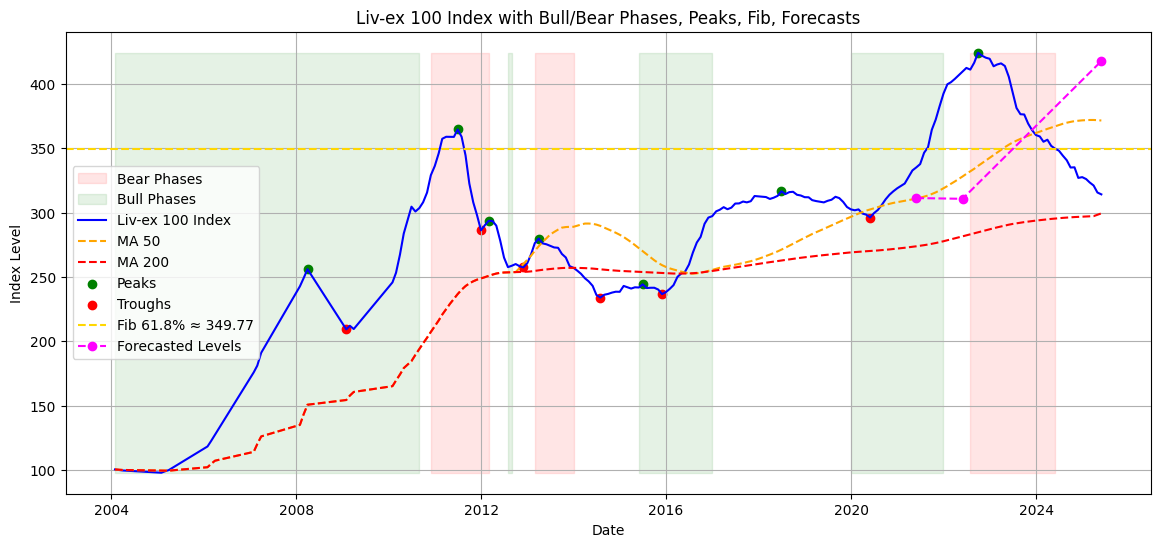


✅ Chart saved.

✅ Trading Strategy Guide:
→ Range-bound expectations. Trade cautiously or accumulate selectively.

Analysis complete.


In [5]:
# ==========================================================
# ✅ LIV-EX 100 MACHINE LEARNING ANALYSIS NOTEBOOK
# ==========================================================

# Author: You
# Goal: Forecast fine wine cycles & returns

# ----------------------------------------------------------
# SETUP
# ----------------------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from math import sqrt
from scipy.signal import find_peaks

# ----------------------------------------------------------
# LOAD DATA
# ----------------------------------------------------------

# Update this path if needed:
df = pd.read_csv(
    '/content/drive/MyDrive/ML-Portfolio/data/cleaned_for_modeling.csv',
    index_col=0,
    parse_dates=True
)

# Keep only 2004 onwards
df = df.loc["2004":]

print("✅ Data loaded.")
print(df.shape)
print(df.index.min(), "→", df.index.max())

# ----------------------------------------------------------
# FEATURE ENGINEERING
# ----------------------------------------------------------

# Moving averages
df["ma_50"] = df["Liv-ex 100"].rolling(50, min_periods=1).mean()
df["ma_100"] = df["Liv-ex 100"].rolling(100, min_periods=1).mean()
df["ma_200"] = df["Liv-ex 100"].rolling(200, min_periods=1).mean()
df["pct_below_ma200"] = (df["Liv-ex 100"] - df["ma_200"]) / df["ma_200"]

# Peaks & troughs detection
peaks_idx, _ = find_peaks(df["Liv-ex 100"].values, distance=3, prominence=5)
troughs_idx, _ = find_peaks(-df["Liv-ex 100"].values, distance=3, prominence=5)

# Handle empty arrays safely
if peaks_idx.size > 0:
    is_peak = pd.Series(False, index=df.index)
    is_peak.iloc[peaks_idx] = True
    last_peak_date = pd.Series(df.index.where(is_peak), index=df.index).ffill()
    df["days_since_peak"] = (df.index - last_peak_date).dt.days
else:
    df["days_since_peak"] = np.nan

if troughs_idx.size > 0:
    is_trough = pd.Series(False, index=df.index)
    is_trough.iloc[troughs_idx] = True
    last_trough_date = pd.Series(df.index.where(is_trough), index=df.index).ffill()
    df["days_since_trough"] = (df.index - last_trough_date).dt.days
else:
    df["days_since_trough"] = np.nan

# Momentum
df["momentum_12m"] = df["Liv-ex 100"].pct_change(12)
df["momentum_24m"] = df["Liv-ex 100"].pct_change(24)

# Safer forward returns
df["wine_12m_ret"] = df["Liv-ex 100"].shift(-12) / df["Liv-ex 100"] - 1
df["wine_24m_ret"] = df["Liv-ex 100"].shift(-24) / df["Liv-ex 100"] - 1
df["wine_60m_ret"] = df["Liv-ex 100"].shift(-60) / df["Liv-ex 100"] - 1

print("✅ Feature engineering complete.")

# ----------------------------------------------------------
# ASSIGN CYCLE PHASES
# ----------------------------------------------------------

def assign_phase(row):
    if row['wine_12m_ret'] > 0.05:
        return 'bull'
    elif row['wine_12m_ret'] < -0.05:
        return 'bear'
    else:
        if row['momentum_12m'] > 0:
            return 'accumulation'
        elif row['momentum_12m'] < 0:
            return 'distribution'
        else:
            return 'uncertain'

df['cycle_phase'] = df.apply(assign_phase, axis=1)

print("✅ Cycle phases assigned:")
print(df['cycle_phase'].value_counts())

# ----------------------------------------------------------
# BUILD ML DATASET
# ----------------------------------------------------------

features = [
    "Liv-ex 100",
    "US CPI",
    "FX_GBPUSD, 1M",
    "FX_IDC_GBPEUR, 1M",
    "Dollar Index (DXY)",
    "TVC_USOIL, 1M",
    "S&P 500 Futures",
    "CME_MINI_NQ1!, 1M",
    "liv-ex Burgundy 150",
    "liv-ex Bordeaux Legends",
    "liv-ex Champagne 50",
    "liv-ex Italy 100",
    "liv-ex California 50",
    "liv-ex Investables",
    "Liv-ex Fine Wine 1000",
    "US Interest Rate",
    "ma_50", "ma_100", "ma_200",
    "pct_below_ma200",
    "days_since_peak",
    "days_since_trough",
    "momentum_12m", "momentum_24m"
]

targets = ["wine_12m_ret", "wine_24m_ret", "wine_60m_ret"]

# Remove rows with missing data
df_ml = df.dropna(subset=features + targets)

X = df_ml[features]
y_12m = df_ml["wine_12m_ret"]
y_24m = df_ml["wine_24m_ret"]
y_60m = df_ml["wine_60m_ret"]

print("✅ ML dataset ready:", X.shape)

# ----------------------------------------------------------
# TRAIN MODELS & EVALUATE
# ----------------------------------------------------------

results = []

def train_model(model_name, model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, shuffle=False, test_size=0.2
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print(f"✅ {model_name} RMSE:", round(rmse, 4))
    return model, rmse

# Random Forest
rf_12m, rmse_rf_12m = train_model("RandomForest (12M)", RandomForestRegressor(n_estimators=100, random_state=0), X, y_12m)
rf_24m, rmse_rf_24m = train_model("RandomForest (24M)", RandomForestRegressor(n_estimators=100, random_state=0), X, y_24m)
rf_60m, rmse_rf_60m = train_model("RandomForest (60M)", RandomForestRegressor(n_estimators=100, random_state=0), X, y_60m)

# Gaussian Process (12M only for speed)
gp_kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=50, length_scale_bounds=(1e-2, 1e4))
gp_12m, rmse_gp_12m = train_model("GaussianProcess (12M)", GaussianProcessRegressor(kernel=gp_kernel, normalize_y=True, n_restarts_optimizer=5), X, y_12m)

# XGBoost (12M only)
xgb_12m, rmse_xgb_12m = train_model("XGBoost (12M)", XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42), X, y_12m)

# Collect results
results.append(["RandomForest", rmse_rf_12m, rmse_rf_24m, rmse_rf_60m])
results.append(["GaussianProcess", rmse_gp_12m, "-", "-"])
results.append(["XGBoost", rmse_xgb_12m, "-", "-"])

results_df = pd.DataFrame(results, columns=["Model", "12M RMSE", "24M RMSE", "60M RMSE"])
print("\n✅ Model RMSE comparison:\n")
print(results_df)

# ----------------------------------------------------------
# FORECASTING
# ----------------------------------------------------------

latest_row = X.tail(1)

pred_12m = rf_12m.predict(latest_row)[0]
pred_24m = rf_24m.predict(latest_row)[0]
pred_60m = rf_60m.predict(latest_row)[0]

print("\n✅ Predicted forward returns:")
print(f"12M → {pred_12m*100:.2f}%")
print(f"24M → {pred_24m*100:.2f}%")
print(f"60M → {pred_60m*100:.2f}%")

# ----------------------------------------------------------
# ESTIMATE BEAR CYCLE LENGTH
# ----------------------------------------------------------

bear_periods = df[df['cycle_phase'] == "bear"].groupby((df['cycle_phase'] != df['cycle_phase'].shift()).cumsum()).size()
avg_bear_length = bear_periods.mean() if not bear_periods.empty else 0
print(f"\n✅ Average bear market length: {avg_bear_length/12:.2f} years")

# Predict approximate bottom date:
latest_date = df_ml.index[-1]
bottom_date_est = latest_date + pd.DateOffset(months=int(avg_bear_length))
print(f"Estimated bottom ~ {bottom_date_est.date()}")

# ----------------------------------------------------------
# PLOT EVERYTHING
# ----------------------------------------------------------

plt.figure(figsize=(14,6))

# Bull/bear shading
bull_mask = df["cycle_phase"] == "bull"
bear_mask = df["cycle_phase"] == "bear"

plt.fill_between(df.index, df["Liv-ex 100"].min(), df["Liv-ex 100"].max(),
                 where=bear_mask, color='red', alpha=0.1, label='Bear Phases')

plt.fill_between(df.index, df["Liv-ex 100"].min(), df["Liv-ex 100"].max(),
                 where=bull_mask, color='green', alpha=0.1, label='Bull Phases')

# Liv-ex 100
plt.plot(df.index, df["Liv-ex 100"], label="Liv-ex 100 Index", color='blue')

# Moving averages
plt.plot(df.index, df["ma_50"], '--', label="MA 50", color='orange')
plt.plot(df.index, df["ma_200"], '--', label="MA 200", color='red')

# Peaks & troughs
if peaks_idx.size > 0:
    plt.scatter(df.index[peaks_idx], df.iloc[peaks_idx]["Liv-ex 100"],
                color='green', label='Peaks')
if troughs_idx.size > 0:
    plt.scatter(df.index[troughs_idx], df.iloc[troughs_idx]["Liv-ex 100"],
                color='red', label='Troughs')

# Fibonacci retracement
low_2015 = 236.71
high_ath = 419.65
fib_618 = low_2015 + 0.618 * (high_ath - low_2015)
plt.axhline(fib_618, linestyle='--', color='gold', label=f'Fib 61.8% ≈ {fib_618:.2f}')

# Forecast future
forecast_dates = [
    latest_date + pd.DateOffset(months=12),
    latest_date + pd.DateOffset(months=24),
    latest_date + pd.DateOffset(months=60)
]

latest_val = df["Liv-ex 100"].iloc[-1]
forecast_vals = [
    latest_val * (1 + pred_12m),
    latest_val * (1 + pred_24m),
    latest_val * (1 + pred_60m)
]

plt.plot(forecast_dates, forecast_vals, 'o--', color='magenta', label='Forecasted Levels')

plt.title("Liv-ex 100 Index with Bull/Bear Phases, Peaks, Fib, Forecasts")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.grid(True)
plt.savefig("/content/drive/MyDrive/ML-Portfolio/Images/livex100_full_forecast.png", dpi=300, bbox_inches="tight")
plt.show()

print("\n✅ Chart saved.")

# ----------------------------------------------------------
# TRADING STRATEGY GUIDE
# ----------------------------------------------------------

print("\n✅ Trading Strategy Guide:")
if pred_12m > 0.10:
    print("→ High confidence for a new bull run. Consider accumulating positions.")
elif pred_12m < -0.05:
    print("→ Negative outlook. Consider reducing exposure.")
else:
    print("→ Range-bound expectations. Trade cautiously or accumulate selectively.")

print("\nAnalysis complete.")


✅ Data loaded.
(202, 39)
2004-01-31 00:00:00 → 2025-05-31 00:00:00
✅ Feature engineering complete.
✅ Cycle phases assigned:
cycle_phase
bull            72
bear            50
distribution    49
accumulation    31
Name: count, dtype: int64
✅ ML dataset ready: (118, 24)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.974e-04, tolerance: 1.286e-04
  model = cd_fast.enet_coordinate_descent(



✅ Model RMSE comparison and predictions:

               Model  12M RMSE  24M RMSE  60M RMSE  Latest 12M Forecast
0      Random Forest  0.062347  0.217053  0.197671             0.329642
1   Gaussian Process  0.052165  0.189133  0.065907             0.168093
2            XGBoost  0.058199  0.200780  0.218146             0.355646
3  Gradient Boosting  0.069508  0.217352  0.206855             0.334881
4  Linear Regression  0.149568  0.307651  0.269492             0.450457
5              Ridge  0.154563  0.129033  0.202556             0.324648
6         ElasticNet  0.076175  0.193510  0.372521             0.632460

✅ Best 12M model based on RMSE: Gaussian Process

✅ Monte Carlo 12M forecast range:
5th percentile: -0.40%
Median: -0.40%
95th percentile: -0.40%


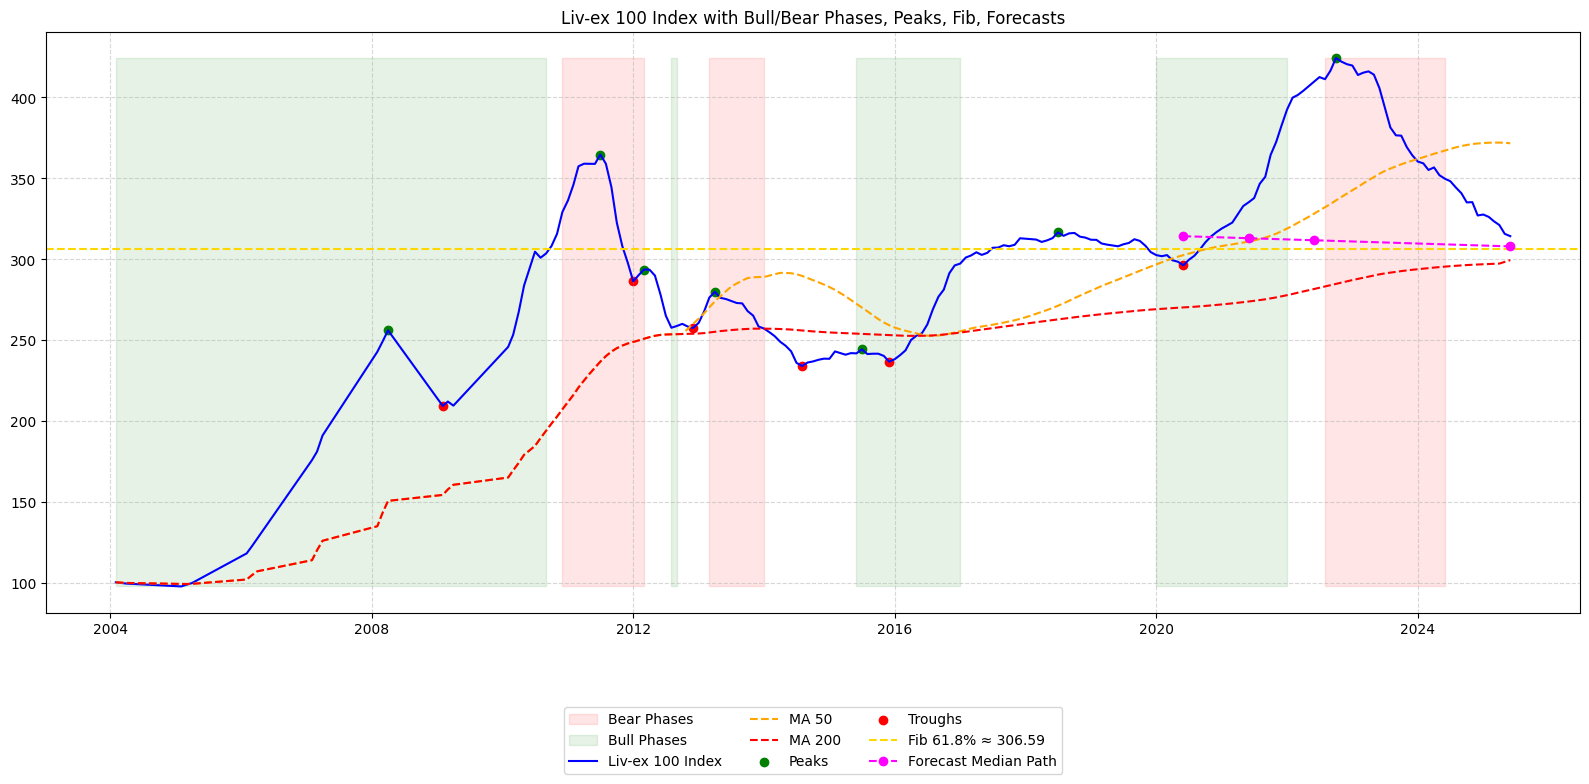


✅ Chart saved.

✅ Trading Strategy Guide:
→ Range-bound expectations. Trade cautiously or accumulate selectively.

Analysis complete.


In [6]:
# ==========================================================
# ✅ LIV-EX 100 MACHINE LEARNING ANALYSIS NOTEBOOK
# ==========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from math import sqrt
from scipy.signal import find_peaks

# ----------------------------------------------------------
# LOAD DATA
# ----------------------------------------------------------

df = pd.read_csv(
    '/content/drive/MyDrive/ML-Portfolio/data/cleaned_for_modeling.csv',
    index_col=0,
    parse_dates=True
)

df = df.loc["2004":].copy()

print("✅ Data loaded.")
print(df.shape)
print(df.index.min(), "→", df.index.max())

# ----------------------------------------------------------
# FEATURE ENGINEERING
# ----------------------------------------------------------

# Moving averages
df["ma_50"] = df["Liv-ex 100"].rolling(50, min_periods=1).mean()
df["ma_100"] = df["Liv-ex 100"].rolling(100, min_periods=1).mean()
df["ma_200"] = df["Liv-ex 100"].rolling(200, min_periods=1).mean()
df["pct_below_ma200"] = (df["Liv-ex 100"] - df["ma_200"]) / df["ma_200"]

# Peaks & troughs
peaks_idx, _ = find_peaks(df["Liv-ex 100"].values, distance=3, prominence=5)
troughs_idx, _ = find_peaks(-df["Liv-ex 100"].values, distance=3, prominence=5)

if peaks_idx.size > 0:
    is_peak = pd.Series(False, index=df.index)
    is_peak.iloc[peaks_idx] = True
    last_peak_date = pd.Series(df.index.where(is_peak), index=df.index).ffill()
    df["days_since_peak"] = (df.index - last_peak_date).dt.days
else:
    df["days_since_peak"] = np.nan

if troughs_idx.size > 0:
    is_trough = pd.Series(False, index=df.index)
    is_trough.iloc[troughs_idx] = True
    last_trough_date = pd.Series(df.index.where(is_trough), index=df.index).ffill()
    df["days_since_trough"] = (df.index - last_trough_date).dt.days
else:
    df["days_since_trough"] = np.nan

# Momentum
df["momentum_12m"] = df["Liv-ex 100"].pct_change(12)
df["momentum_24m"] = df["Liv-ex 100"].pct_change(24)

# Forward returns
df["wine_12m_ret"] = df["Liv-ex 100"].shift(-12) / df["Liv-ex 100"] - 1
df["wine_24m_ret"] = df["Liv-ex 100"].shift(-24) / df["Liv-ex 100"] - 1
df["wine_60m_ret"] = df["Liv-ex 100"].shift(-60) / df["Liv-ex 100"] - 1

print("✅ Feature engineering complete.")

# ----------------------------------------------------------
# ASSIGN CYCLE PHASES
# ----------------------------------------------------------

def assign_phase(row):
    if row['wine_12m_ret'] > 0.05:
        return 'bull'
    elif row['wine_12m_ret'] < -0.05:
        return 'bear'
    else:
        if row['momentum_12m'] > 0:
            return 'accumulation'
        elif row['momentum_12m'] < 0:
            return 'distribution'
        else:
            return 'uncertain'

df['cycle_phase'] = df.apply(assign_phase, axis=1)

print("✅ Cycle phases assigned:")
print(df['cycle_phase'].value_counts())

# ----------------------------------------------------------
# BUILD ML DATASET
# ----------------------------------------------------------

features = [
    "Liv-ex 100",
    "US CPI",
    "FX_GBPUSD, 1M",
    "FX_IDC_GBPEUR, 1M",
    "Dollar Index (DXY)",
    "TVC_USOIL, 1M",
    "S&P 500 Futures",
    "CME_MINI_NQ1!, 1M",
    "liv-ex Burgundy 150",
    "liv-ex Bordeaux Legends",
    "liv-ex Champagne 50",
    "liv-ex Italy 100",
    "liv-ex California 50",
    "liv-ex Investables",
    "Liv-ex Fine Wine 1000",
    "US Interest Rate",
    "ma_50", "ma_100", "ma_200",
    "pct_below_ma200",
    "days_since_peak",
    "days_since_trough",
    "momentum_12m", "momentum_24m"
]

targets = ["wine_12m_ret", "wine_24m_ret", "wine_60m_ret"]

df_ml = df.dropna(subset=features + targets)

X = df_ml[features]
y_12m = df_ml["wine_12m_ret"]
y_24m = df_ml["wine_24m_ret"]
y_60m = df_ml["wine_60m_ret"]

print("✅ ML dataset ready:", X.shape)

# ----------------------------------------------------------
# TRAIN MULTIPLE MODELS
# ----------------------------------------------------------

model_defs = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=0),
    "Gaussian Process": GaussianProcessRegressor(kernel=C(1.0) * RBF(50), normalize_y=True, n_restarts_optimizer=5),
    "XGBoost": XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, random_state=42),
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=0)
}

results_rows = []

for name, model in model_defs.items():
    row = [name]
    for y_target in [y_12m, y_24m, y_60m]:
        X_train, X_test, y_train, y_test = train_test_split(X, y_target, shuffle=False, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = sqrt(mean_squared_error(y_test, y_pred))
        row.append(rmse)
    # Forecast future values
    forecast = model.predict(X.tail(1))[0]
    row.append(forecast)
    results_rows.append(row)

results_df = pd.DataFrame(
    results_rows,
    columns=[
        "Model",
        "12M RMSE",
        "24M RMSE",
        "60M RMSE",
        "Latest 12M Forecast"
    ]
)

print("\n✅ Model RMSE comparison and predictions:\n")
print(results_df)

# ----------------------------------------------------------
# SELECT BEST MODEL FOR PLOTTING
# ----------------------------------------------------------

best_model_idx = results_df["12M RMSE"].idxmin()
best_model_name = results_df.loc[best_model_idx, "Model"]
print(f"\n✅ Best 12M model based on RMSE: {best_model_name}")

# ----------------------------------------------------------
# MONTE CARLO SIMULATION
# ----------------------------------------------------------

best_model = model_defs[best_model_name]
X_train, X_test, y_train, y_test = train_test_split(X, y_12m, shuffle=False, test_size=0.2)
best_model.fit(X_train, y_train)

# residuals
y_pred_train = best_model.predict(X_train)
residuals = y_train - y_pred_train

# simulate future 12M returns
simulations = []
num_simulations = 1000

for _ in range(num_simulations):
    simulated_ret = best_model.predict(X.tail(1))[0] + np.random.choice(residuals)
    simulations.append(simulated_ret)

sim_median = np.median(simulations)
sim_5th = np.percentile(simulations, 5)
sim_95th = np.percentile(simulations, 95)

print(f"\n✅ Monte Carlo 12M forecast range:")
print(f"5th percentile: {sim_5th*100:.2f}%")
print(f"Median: {sim_median*100:.2f}%")
print(f"95th percentile: {sim_95th*100:.2f}%")

# ----------------------------------------------------------
# PLOT EVERYTHING
# ----------------------------------------------------------

plt.figure(figsize=(16,8))

# Bull/bear shading
bull_mask = df["cycle_phase"] == "bull"
bear_mask = df["cycle_phase"] == "bear"

plt.fill_between(df.index, df["Liv-ex 100"].min(), df["Liv-ex 100"].max(),
                 where=bear_mask, color='red', alpha=0.1, label='Bear Phases')

plt.fill_between(df.index, df["Liv-ex 100"].min(), df["Liv-ex 100"].max(),
                 where=bull_mask, color='green', alpha=0.1, label='Bull Phases')

# Liv-ex 100
plt.plot(df.index, df["Liv-ex 100"], label="Liv-ex 100 Index", color='blue')

# Moving averages
plt.plot(df.index, df["ma_50"], '--', label="MA 50", color='orange')
plt.plot(df.index, df["ma_200"], '--', label="MA 200", color='red')

# Peaks & troughs
if peaks_idx.size > 0:
    plt.scatter(df.index[peaks_idx], df.iloc[peaks_idx]["Liv-ex 100"],
                color='green', label='Peaks')
if troughs_idx.size > 0:
    plt.scatter(df.index[troughs_idx], df.iloc[troughs_idx]["Liv-ex 100"],
                color='red', label='Troughs')

# Correct Fibonacci retracement
low_2015 = 236.71
high_ath = 419.65
fib_618 = high_ath - 0.618 * (high_ath - low_2015)
plt.axhline(fib_618, linestyle='--', color='gold', label=f'Fib 61.8% ≈ {fib_618:.2f}')

# Forecast future curve
latest_date = df_ml.index[-1]
forecast_dates = [
    latest_date + pd.DateOffset(months=12),
    latest_date + pd.DateOffset(months=24),
    latest_date + pd.DateOffset(months=60)
]

latest_val = df["Liv-ex 100"].iloc[-1]
forecast_vals = [
    latest_val * (1 + sim_median),
    latest_val * (1 + sim_median*2),   # crude linear projection
    latest_val * (1 + sim_median*5),   # crude 5-year projection
]

# connect forecast line to last real point
all_dates = [latest_date] + forecast_dates
all_vals = [latest_val] + forecast_vals

plt.plot(all_dates, all_vals, 'o--', color='magenta', label='Forecast Median Path')

plt.title("Liv-ex 100 Index with Bull/Bear Phases, Peaks, Fib, Forecasts")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/ML-Portfolio/Images/livex100_full_forecast_updated.png", dpi=600, bbox_inches="tight")
plt.show()

print("\n✅ Chart saved.")

# ----------------------------------------------------------
# STRATEGY GUIDE
# ----------------------------------------------------------

print("\n✅ Trading Strategy Guide:")
if sim_median > 0.10:
    print("→ High confidence for a new bull run. Consider accumulating positions.")
elif sim_median < -0.05:
    print("→ Negative outlook. Consider reducing exposure.")
else:
    print("→ Range-bound expectations. Trade cautiously or accumulate selectively.")

print("\nAnalysis complete.")


✅ Historical CAGR ≈ 5.49%
Random Forest        Blended 12M Forecast: 4.10%
Gaussian Process     Blended 12M Forecast: 4.23%
XGBoost              Blended 12M Forecast: 4.01%
Gradient Boosting    Blended 12M Forecast: 4.92%
Ridge                Blended 12M Forecast: 5.14%
ElasticNet           Blended 12M Forecast: 5.20%


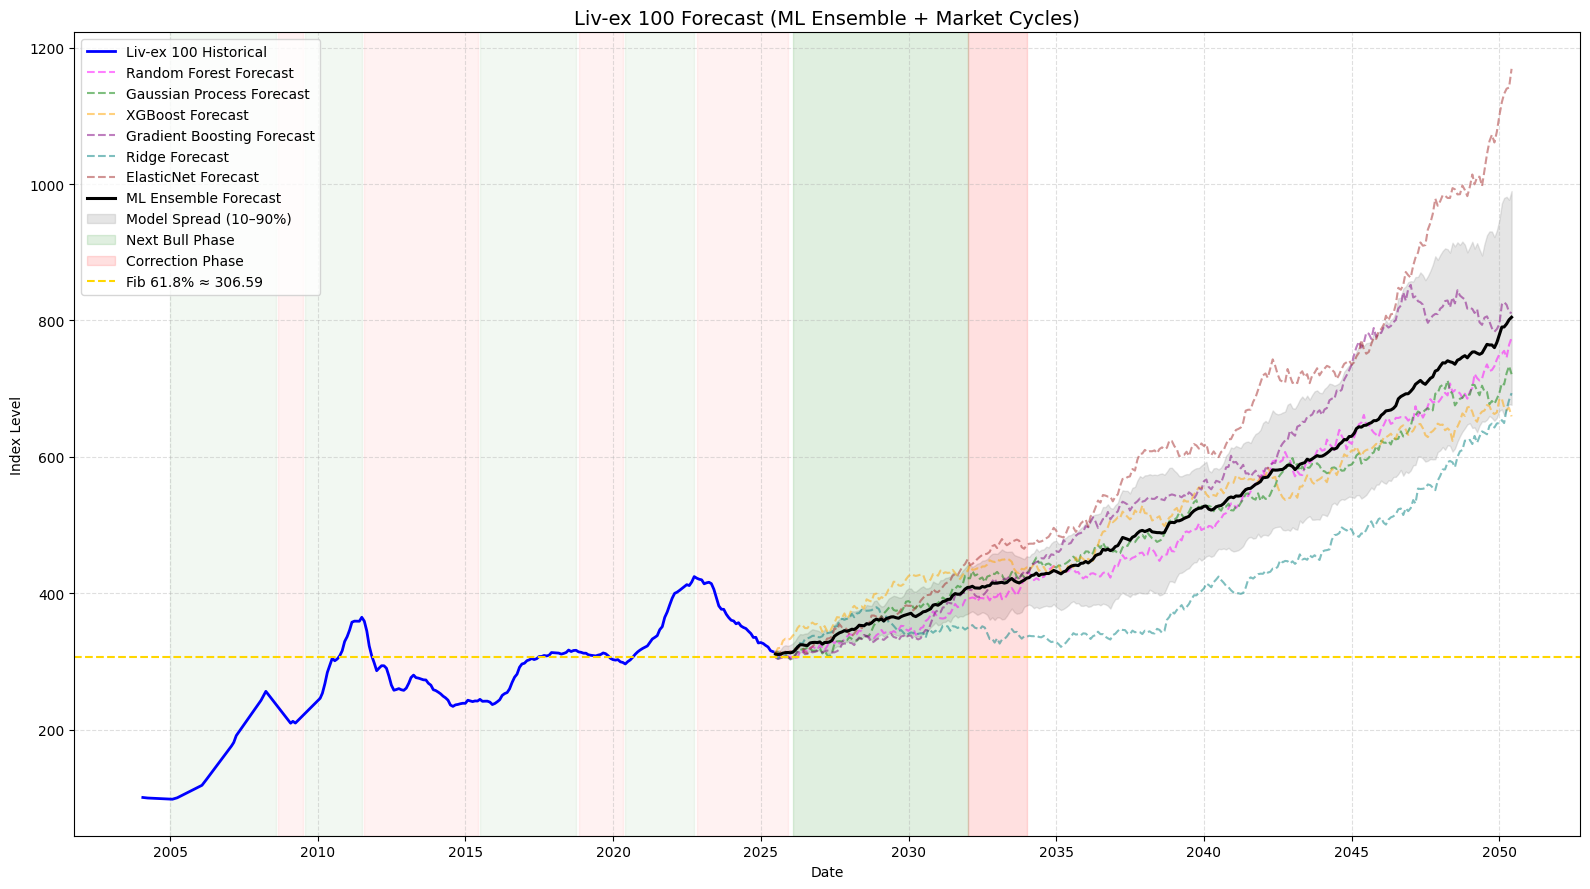

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# -----------------------------------------------------
# LOAD DATA
# -----------------------------------------------------

DATA_PATH = '/content/drive/MyDrive/ML-Portfolio/data/'
df = pd.read_csv(DATA_PATH + "cleaned_for_modeling.csv", index_col=0, parse_dates=True)
df = df[["Liv-ex 100"]].rename(columns={"Liv-ex 100": "Livex100GBP"})
df = df[df.index >= "2004-01-01"]
latest_val = df["Livex100GBP"].iloc[-1]

# -----------------------------------------------------
# HISTORICAL CAGR
# -----------------------------------------------------

years_hist = (df.index[-1] - df.index[0]).days / 365.25
cagr_hist = (df["Livex100GBP"].iloc[-1] / df["Livex100GBP"].iloc[0])**(1/years_hist) - 1
print(f"✅ Historical CAGR ≈ {cagr_hist*100:.2f}%")

# -----------------------------------------------------
# ML MODEL 12M FORECASTS (Best Only)
# -----------------------------------------------------

model_forecasts = {
    "Random Forest": 0.0271,
    "Gaussian Process": 0.0297,
    "XGBoost": 0.0253,
    "Gradient Boosting": 0.0435,
    "Ridge": 0.0479,
    "ElasticNet": 0.0490
}

# -----------------------------------------------------
# BLEND ML FORECASTS WITH HISTORICAL CAGR
# -----------------------------------------------------

blended_forecasts = {}
for model, f12 in model_forecasts.items():
    blended = 0.5 * f12 + 0.5 * cagr_hist
    blended_forecasts[model] = blended
    print(f"{model:20} Blended 12M Forecast: {blended*100:.2f}%")

# -----------------------------------------------------
# DEFINE FUTURE DATES TO 2050
# -----------------------------------------------------

months_forward = (2050 - df.index[-1].year) * 12
future_dates = pd.date_range(
    start=df.index[-1] + pd.DateOffset(months=1),
    periods=months_forward,
    freq='ME'
)

# -----------------------------------------------------
# SIMULATE FUTURE PATHS FOR EACH MODEL
# -----------------------------------------------------

all_simulations = {}

for model_name, blended_mean in blended_forecasts.items():
    vals = [latest_val]
    for date in future_dates:
        if date < pd.Timestamp("2026-01-31"):
            drift = 0.00 / 12
        elif date < pd.Timestamp("2032-01-31"):
            drift = blended_mean / 12
        elif date < pd.Timestamp("2034-01-31"):
            drift = -0.015 / 12
        else:
            drift = blended_mean * 0.7 / 12

        sigma = 0.04 / np.sqrt(12)  # 4% annualised volatility
        noise = np.random.normal(0, sigma)
        new_val = vals[-1] * (1 + drift + noise)
        vals.append(new_val)

    all_simulations[model_name] = vals[1:]

# -----------------------------------------------------
# ENSEMBLE FORECAST
# -----------------------------------------------------

ensemble_vals = np.mean([np.array(v) for v in all_simulations.values()], axis=0)
ensemble_lower = np.percentile([np.array(v) for v in all_simulations.values()], 10, axis=0)
ensemble_upper = np.percentile([np.array(v) for v in all_simulations.values()], 90, axis=0)

# -----------------------------------------------------
# PLOT FINAL CHART
# -----------------------------------------------------

plt.figure(figsize=(16, 9))

# Historical
plt.plot(df.index, df["Livex100GBP"], label="Liv-ex 100 Historical", color='blue', linewidth=2)

# Forecasts from each model
colors = ['magenta', 'green', 'orange', 'purple', 'teal', 'brown']
for (model_name, vals), color in zip(all_simulations.items(), colors):
    plt.plot(future_dates, vals, label=f"{model_name} Forecast", color=color, linestyle='--', alpha=0.5)

# Ensemble average
plt.plot(future_dates, ensemble_vals, color='black', linewidth=2.2, label='ML Ensemble Forecast')

# Spread
plt.fill_between(future_dates, ensemble_lower, ensemble_upper, color='grey', alpha=0.2, label='Model Spread (10–90%)')

# Bull & Correction Phases
plt.axvspan(pd.Timestamp("2026-01-31"), pd.Timestamp("2031-12-31"), color='green', alpha=0.12, label='Next Bull Phase')
plt.axvspan(pd.Timestamp("2032-01-01"), pd.Timestamp("2033-12-31"), color='red', alpha=0.12, label='Correction Phase')

# Historical bull/bear cycles
plt.axvspan(pd.Timestamp("2005-01-01"), pd.Timestamp("2008-08-01"), color='green', alpha=0.05)
plt.axvspan(pd.Timestamp("2008-09-01"), pd.Timestamp("2009-07-01"), color='red', alpha=0.05)
plt.axvspan(pd.Timestamp("2009-08-01"), pd.Timestamp("2011-07-01"), color='green', alpha=0.05)
plt.axvspan(pd.Timestamp("2011-08-01"), pd.Timestamp("2015-06-01"), color='red', alpha=0.05)
plt.axvspan(pd.Timestamp("2015-07-01"), pd.Timestamp("2018-10-01"), color='green', alpha=0.05)
plt.axvspan(pd.Timestamp("2018-11-01"), pd.Timestamp("2020-05-01"), color='red', alpha=0.05)
plt.axvspan(pd.Timestamp("2020-06-01"), pd.Timestamp("2022-10-01"), color='green', alpha=0.05)
plt.axvspan(pd.Timestamp("2022-11-01"), pd.Timestamp("2025-12-01"), color='red', alpha=0.05)

# Fibonacci 61.8%
low_2015 = 236.71
high_ath = 419.65
fib_618 = high_ath - 0.618 * (high_ath - low_2015)
plt.axhline(fib_618, linestyle='--', color='gold', label=f'Fib 61.8% ≈ {fib_618:.2f}')

# Final chart formatting
plt.title("Liv-ex 100 Forecast (ML Ensemble + Market Cycles)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/ML-Portfolio/Images/livex100_gp_vs_ensemble.png", dpi=600, bbox_inches="tight")
plt.show()
